<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Nuclear-fraction" data-toc-modified-id="Nuclear-fraction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Nuclear fraction</a></span><ul class="toc-item"><li><span><a href="#Fitting-the-nuclear-fraction" data-toc-modified-id="Fitting-the-nuclear-fraction-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Fitting the nuclear fraction</a></span></li></ul></li><li><span><a href="#Bound-RNA-vs-size" data-toc-modified-id="Bound-RNA-vs-size-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Bound RNA vs size</a></span></li><li><span><a href="#Fitting-functions" data-toc-modified-id="Fitting-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Fitting functions</a></span></li></ul></li><li><span><a href="#Fitting-Haploid-data" data-toc-modified-id="Fitting-Haploid-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fitting Haploid data</a></span><ul class="toc-item"><li><span><a href="#Validating-on-diploid-data" data-toc-modified-id="Validating-on-diploid-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Validating on diploid data</a></span></li></ul></li><li><span><a href="#Predicting-the-single-molecule-data" data-toc-modified-id="Predicting-the-single-molecule-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Predicting the single molecule data</a></span></li><li><span><a href="#Bootstrap-fitting-on-the-parameters" data-toc-modified-id="Bootstrap-fitting-on-the-parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bootstrap fitting on the parameters</a></span></li><li><span><a href="#CIs-for-the-SMT-data" data-toc-modified-id="CIs-for-the-SMT-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CIs for the SMT data</a></span></li><li><span><a href="#CIs-on-diploid-data" data-toc-modified-id="CIs-on-diploid-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>CIs on diploid data</a></span></li><li><span><a href="#Export-files" data-toc-modified-id="Export-files-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Export files</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.optimize import curve_fit

# Load data

## Nuclear fraction

In [3]:
vols = pd.read_csv("nuc_vol.txt", delimiter="\t", header=None)

In [4]:
COL_RENAME = {0: 'cell_volume', 1: 'nuclear_volume'}

In [5]:
vols=vols.rename(columns = COL_RENAME)

In [6]:
vols['cell_volume'] = vols['cell_volume']/1.5

In [7]:
vols['nuc_frac'] = vols['nuclear_volume']/vols['cell_volume']

### Fitting the nuclear fraction

In [8]:
offset=15

In [9]:
def nuc_frac_model(x, alpha, beta, delta): 
    return alpha + beta * np.exp(-delta * (x-offset))

In [10]:
# fit curve
(alpha, beta, delta), _ = curve_fit(nuc_frac_model, vols['cell_volume'], vols['nuc_frac'])

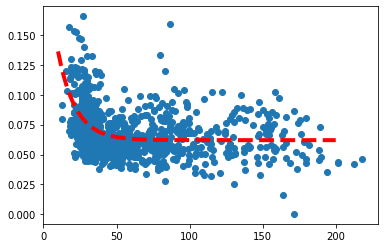

In [11]:
xs = np.linspace(10, 200, 100)

plt.scatter(vols['cell_volume'], vols['nuc_frac'])
plt.plot(xs, nuc_frac_model(xs, alpha, beta, delta), ls = '--', lw=4, c='red')

## Bound RNA vs size

In [12]:
df_ChIP = pd.read_csv('221108_ChIPdata_summary.txt', delimiter='\t').dropna(axis=1)
df_ChIP = df_ChIP.rename(columns={c: c.strip() for c in df_ChIP.columns})

In [13]:
df_SMT = pd.read_csv('221108_SMTdata_summary.txt', delimiter='\t').dropna(axis=1)

In [14]:
df_ChIP

,sample,strain,cell_volume_fL,Rpb1_occupancy_ChIP-seq
0,G1_arrest_haploid_rep1_F01,MS64,29.490101,1.004635
1,G1_arrest_haploid_rep1_F02,MS64,41.549948,1.272252
2,G1_arrest_haploid_rep1_F03,MS64,56.299913,1.501839
3,G1_arrest_haploid_rep1_F04,MS64,72.380058,1.641307
4,G1_arrest_haploid_rep1_F05,MS64,88.470198,1.734719
5,G1_arrest_haploid_rep1_F06,MS64,117.999726,2.004982
6,G1_arrest_haploid_rep1_F07,MS64,143.400121,2.096972
7,G1_arrest_haploid_rep2_F01,MS64,28.149897,1.171544
8,G1_arrest_haploid_rep2_F02,MS64,40.209994,1.291382
9,G1_arrest_haploid_rep2_F03,MS64,53.620008,1.744409


In [15]:
df_SMT

,bin,cell_volume_fL,Rpb1_bound_fraction_mean,Rpb1_bound_fraction_sd,n
0,bin_1,20.715471,0.511801,0.102485,37
1,bin_2,32.794932,0.483243,0.105636,87
2,bin_3,50.657322,0.434892,0.113779,74
3,bin_4,90.471035,0.362999,0.135929,40
4,bin_5,150.480403,0.300707,0.090665,20


## Fitting functions

In [16]:
def nuc_vol_lin(x):
    return  0.038 * x + 0.55

In [17]:
def obj1(x, a, b): 
    """Initial model with constant nuclear fraction"""
    return a*(x/b)/(1+x*b)

def obj2(x, a, b): 
    """Model with nuclear fraction decreasing as 1/x"""
    nuclear_volume = nuc_vol_lin(x)
    return a * (x/b) / (1 + b * nuclear_volume)

def obj3(x, a, b):
    """Model with nuclear fraction decreasing as exp(-delta*x)"""
    nuc_volume = x * (alpha + beta * np.exp(-delta * (x-offset)))
    return a * (x/b) / (1 + b * nuc_volume)

In [18]:
models = ['Constant nuclear fraction', 'Nuclear fraction as 1/x', 'Nuclear fraction as exp(-delta*x)']

# Fitting Haploid data

In [19]:
df_hap = df_ChIP.loc[df_ChIP['strain']=="MS64"]

In [20]:
col_vol = 'cell_volume_fL'
col_RNA = 'Rpb1_occupancy_ChIP-seq'

In [21]:
# fit curve
(a1, b1), _ = curve_fit(obj1, df_hap[col_vol], df_hap[col_RNA])

(a2, b2), _ = curve_fit(obj2, df_hap[col_vol], df_hap[col_RNA])

(a3, b3), _ = curve_fit(obj3, df_hap[col_vol], df_hap[col_RNA])

params_fit=[(a1, b1), (a2, b2), (a3, b3)]

In [22]:
# define new input values
x_new = np.linspace(1,230,100)

# use optimal parameters to calculate new values
y1= obj1(x_new, a1, b1)
y2 = obj2(x_new, a2, b2)
y3 = obj3(x_new, a3, b3)

ys = [y1, y2, y3]

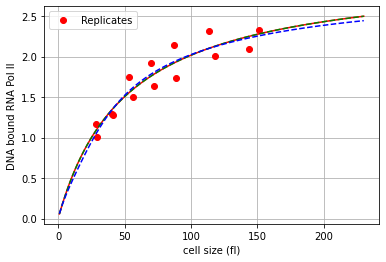

In [23]:
fig = plt.figure()
plt.plot(df_hap[col_vol], df_hap[col_RNA], 'ro', label='Replicates')
plt.plot(x_new, y1, 'r')
plt.plot(x_new, y2, 'g--')
plt.plot(x_new, y3, 'b--')

plt.xlabel('cell size (fl)')
plt.ylabel('DNA bound RNA Pol II')

plt.legend()
plt.grid()

## Validating on diploid data

In [24]:
df_dip = df_ChIP.loc[df_ChIP['strain']=='MS67']

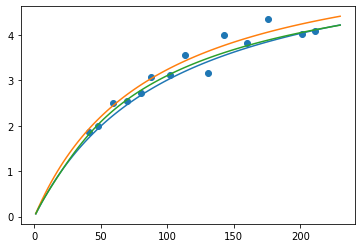

In [25]:
fig = plt.figure()
plt.scatter(df_dip[col_vol], df_dip[col_RNA])

y1_dip = obj1(x_new, a1/2, b1/2)
y2_dip = obj2(x_new, a2/2, b2/2)
y3_dip = obj3(x_new, a3/2, b3/2)

ys_dip = [y1_dip, y2_dip, y3_dip]

plt.plot(x_new, y1_dip)
plt.plot(x_new, y2_dip)
plt.plot(x_new, y3_dip)

# Predicting the single molecule data

In [26]:
col_RNA_frac = 'Rpb1_bound_fraction_mean'

(15.0, 175.0)

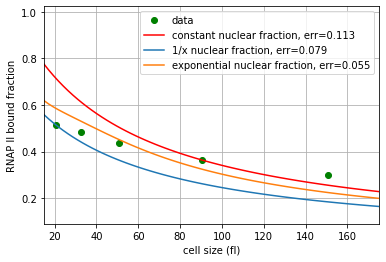

In [27]:
# setting the axes at the centre
fig = plt.figure()

# plot the function
plt.plot(df_SMT[col_vol], df_SMT[col_RNA_frac], 'go', label="data")

err1 = np.sqrt(np.mean((obj1(df_SMT[col_vol], a1, b1)/(a1*df_SMT[col_vol]/b1) - df_SMT[col_RNA_frac])**2))
plt.plot(x_new, y1/(a1*x_new/b1), 'r', label=f"constant nuclear fraction, err={np.around(err1, decimals=3)}")

err2 = np.sqrt(np.mean((obj2(df_SMT[col_vol], a2, b2)/(a2*df_SMT[col_vol]/b2) - df_SMT[col_RNA_frac])**2))
plt.plot(x_new, y2/(a2*x_new/b2), label=f"1/x nuclear fraction, err={np.around(err2, decimals=3)}")

err3 = np.sqrt(np.mean((obj3(df_SMT[col_vol], a3, b3)/(a3*df_SMT[col_vol]/b3) - df_SMT[col_RNA_frac])**2))
plt.plot(x_new, y3/(a3*x_new/b3), label=f"exponential nuclear fraction, err={np.around(err3, decimals=3)}")

plt.legend()
plt.grid()
plt.xlabel('cell size (fl)')
plt.ylabel('RNAP II bound fraction')
plt.xlim([15, 175])


# Bootstrap fitting on the parameters

In [28]:
bag_size = 7
n_fits = 100

params = {1: {'a': [], 'b': []}, 2: {'a': [], 'b': []}, 3: {'a': [], 'b': []}}
preds = {1: [], 2: [], 3: []}
SMT_preds = {1: [], 2: [], 3: []}
DIP_preds = {1: [], 2: [], 3: []}

objs = [obj1, obj2, obj3]

for _ in range(n_fits):
    idx = np.random.choice(len(df_hap), bag_size)
    
    x_crt = df_hap[col_vol].iloc[idx].values
    y_crt = df_hap[col_RNA].iloc[idx].values
    
    for (k, obj) in enumerate(objs):
        (a, b), _ = curve_fit(obj, x_crt, y_crt)
        params[k+1]['a'].append(a)
        params[k+1]['b'].append(b)
        y = obj(x_new, a, b)
        preds[k+1].append(y.reshape(-1, 1))
        SMT_preds[k+1].append((y/(a * x_new/b)).reshape(-1, 1))
        DIP_preds[k+1].append((obj(x_new, a/2, b/2)).reshape(-1, 1))

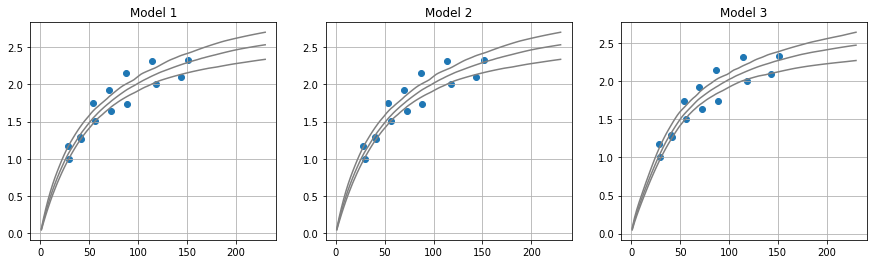

In [29]:
# plotting the quantiles of the predictions
quantiles = [.1, .5, .9]

_, ax = plt.subplots(1, 3, figsize=(15, 4))

for k in range(3):
    Qs = [np.quantile(np.concatenate(preds[k+1], axis=1), q, axis=1) for q in quantiles]
    
    for Q in Qs: 
        ax[k].plot(x_new, Q, color='gray')
    ax[k].scatter(df_hap[col_vol], df_hap[col_RNA])
    
    ax[k].set_title(f"Model {k+1}")
    ax[k].grid()

# CIs for the SMT data

In [30]:
# quantiles of the SMT predictions

SMT_Qs = {1: [], 2: [], 3: []}
quantiles_SMT = [.1, .9]

for k in range(3):
    SMT_Qs[k+1] = [np.quantile(np.concatenate(SMT_preds[k+1], axis=1), q, axis=1) for q in quantiles_SMT]

In [31]:
COLORS = ['firebrick', 'forestgreen', 'darkblue']
alpha_plot=.2

(15.0, 175.0)

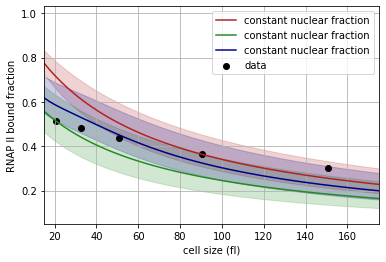

In [32]:
for k in range(3):
    

    plt.fill_between(x_new, SMT_Qs[k+1][0], SMT_Qs[k+1][1], 
                     color = COLORS[k], alpha=alpha_plot
                    )
    plt.plot(
        x_new, ys[k]/(params_fit[k][0]*x_new/params_fit[k][1]), c=COLORS[k], 
        label="constant nuclear fraction"
    )
        
        
# plot the function
plt.scatter(df_SMT[col_vol], df_SMT[col_RNA_frac], color='black', label="data")

plt.legend()
plt.grid()
plt.xlabel('cell size (fl)')
plt.ylabel('RNAP II bound fraction')
plt.xlim([15, 175])

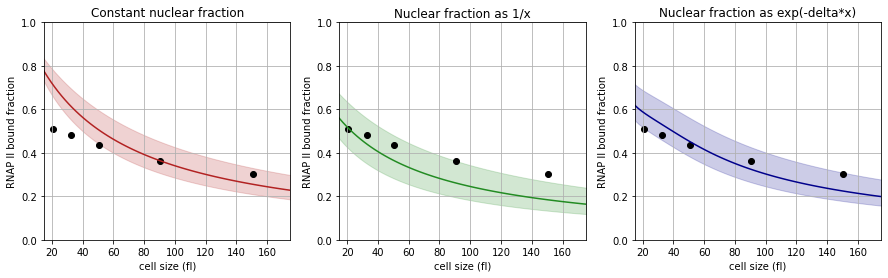

In [33]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))

for k in range(3):
    
    ax[k].fill_between(x_new, SMT_Qs[k+1][0], SMT_Qs[k+1][1], 
                     color = COLORS[k], alpha=alpha_plot
                    )
    ax[k].plot(
        x_new, ys[k]/(params_fit[k][0]*x_new/params_fit[k][1]), c=COLORS[k], 
        label="constant nuclear fraction"
    )
        
        
    # plot the function
    ax[k].scatter(df_SMT[col_vol], df_SMT[col_RNA_frac], color='black', label="data")

#     plt.legend()
    ax[k].grid()
    ax[k].set_xlabel('cell size (fl)')
    ax[k].set_ylabel('RNAP II bound fraction')
    ax[k].set_xlim([15, 175])
    ax[k].set_ylim([0, 1])
    ax[k].set_title(models[k])


# CIs on diploid data

In [34]:
# quantiles of the SMT predictions

DIP_Qs = {1: [], 2: [], 3: []}
quantiles_DIP = [.1, .9]

for k in range(3):
    DIP_Qs[k+1] = [np.quantile(np.concatenate(DIP_preds[k+1], axis=1), q, axis=1) for q in quantiles_DIP]

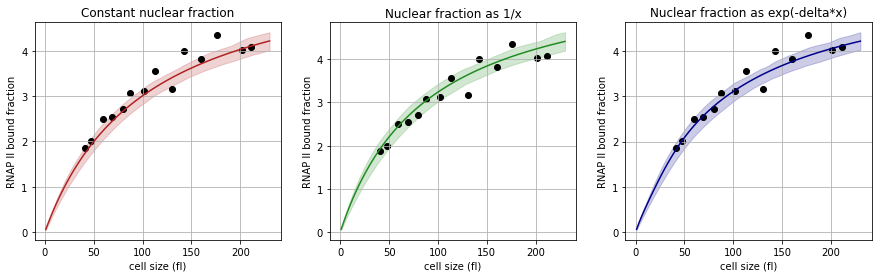

In [35]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))

for k in range(3):
    
    ax[k].fill_between(x_new, DIP_Qs[k+1][0], DIP_Qs[k+1][1], 
                     color = COLORS[k], alpha=alpha_plot
                    )
    ax[k].plot(
        x_new, ys_dip[k], c=COLORS[k], 
        label="constant nuclear fraction"
    )
        
        
    # plot the function
    ax[k].scatter(df_dip[col_vol], df_dip[col_RNA], color='black', label="data")

#     plt.legend()
    ax[k].grid()
    ax[k].set_xlabel('cell size (fl)')
    ax[k].set_ylabel('RNAP II bound fraction')
#     ax[k].set_xlim([15, 175])
#     ax[k].set_ylim([0, 1])
    ax[k].set_title(models[k])


# Export files

In [36]:
model_names = ['constant_nuclear_fraction', 'linear_nuclear_fraction', 'exp_nuclear_fraction']

In [37]:
for (k, model) in enumerate(model_names): 
    df_final = pd.DataFrame()
    df_final.index = x_new
    df_final.index.rename('cell_volume_fL', inplace=True)
    
    df_final['Rpb1_occupancy_haploid_fit'] = ys[k]
    df_final['Rpb1_occupancy_haploid_fit_10pc'] = 0
    df_final['Rpb1_occupancy_haploid_fit_90pc'] = 0
    
    df_final['Rpb1_occupancy_diploid_prediction'] = ys_dip[k]
    df_final['Rpb1_occupancy_diploid_prediction_10pc'] = DIP_Qs[k+1][0]
    df_final['Rpb1_occupancy_diploid_prediction_90pc'] = DIP_Qs[k+1][1]
    
    df_final['Rpb1_bound_fraction_haploid_prediction'] = ys[k]/(params_fit[k][0] * x_new/params_fit[k][1])
    df_final['Rpb1_bound_fraction_haploid_prediction_10pc'] = SMT_Qs[k+1][0]
    df_final['Rpb1_bound_fraction_haploid_prediction_90pc'] = SMT_Qs[k+1][1]
    
    if k==0:
        nuc_vol = "?"
    elif k==1:
        nuc_vol = nuc_vol_lin(x_new)
    elif k==2:
        nuc_vol = nuc_frac_model(x_new, alpha, beta, delta) * x_new
    
    df_final['nuclear_volume'] = nuc_vol
    
    df_final.to_csv(f"data_{model}.csv")